In [1]:
from functools import partial, wraps
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import matplotlib.pyplot as plt; plt.style.use("ggplot")
import seaborn as sns; sns.set()

import tensorflow as tf
import tensorflow_probability as tfp

from tensorflow_probability import bijectors as tfb
from tensorflow_probability import distributions as tfd

In [2]:
def probablistic_pca(data_dim, latent_dim, num_datapoints, stddv_datapoints):
  w = yield tfd.Normal(
    loc=tf.zeros([data_dim, latent_dim]),
    scale=2.0 * tf.ones([data_dim, latent_dim]),
    name="w"
  )
  z = yield tfd.Normal(
    loc=tf.zeros([latent_dim, num_datapoints]),
    scale=tf.ones([latent_dim, num_datapoints]),
    name="z"
  )
  x = yield tfd.Normal(
    loc=tf.matmul(w, z),
    scale=stddv_datapoints,
    name="x"
  )

In [3]:
num_datapoints = 5000
data_dim = 2
latent_dim = 1
stddv_datapoints = 0.5

concrete_ppca_model = partial(probablistic_pca,
                              data_dim=data_dim,
                              latent_dim=latent_dim,
                              num_datapoints=num_datapoints,
                              stddv_datapoints=stddv_datapoints
                             )

model = tfd.JointDistributionCoroutineAutoBatched(concrete_ppca_model)

In [4]:
actual_w, actual_z, x_train = model.sample()

print("Principal axes:")
print(actual_w)

Principal axes:
tf.Tensor(
[[-0.9908767 ]
 [-0.01656692]], shape=(2, 1), dtype=float32)


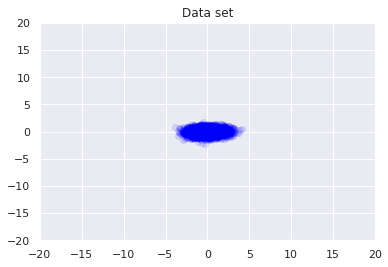

In [5]:
plt.scatter(x_train[0, :], x_train[1, :], color='blue', alpha=0.1)
plt.axis([-20, 20, -20, 20])
plt.title("Data set")
plt.show()

In [6]:
w = tf.Variable(tf.ones([data_dim, latent_dim]))
z = tf.Variable(tf.ones([latent_dim, num_datapoints]))

target_log_prob_fn = lambda w, z: model.log_prob((w, z, x_train))
losses = tfp.math.minimize(
    lambda: -target_log_prob_fn(w, z),
    optimizer=tf.optimizers.Adam(learning_rate=0.05),
    num_steps=200)

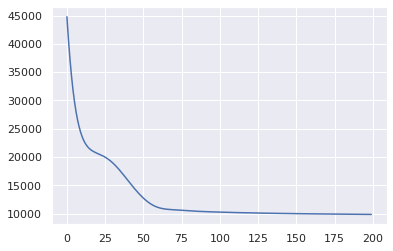

In [7]:
plt.plot(losses);

MAP-estimated axes:
<tf.Variable 'Variable:0' shape=(2, 1) dtype=float32, numpy=
array([[2.488607  ],
       [0.06509817]], dtype=float32)>


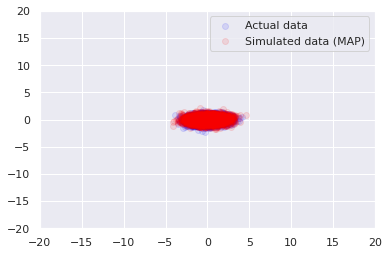

In [8]:
print("MAP-estimated axes:")
print(w)

_, _, x_generated = model.sample(value=(w, z, None))

plt.scatter(x_train[0, :], x_train[1, :], color='blue', alpha=0.1, label='Actual data')
plt.scatter(x_generated[0, :], x_generated[1, :], color='red', alpha=0.1, label='Simulated data (MAP)')
plt.legend()
plt.axis([-20, 20, -20, 20])
plt.show()

In [9]:
qw_mean = tf.Variable(tf.ones([data_dim, latent_dim]))
qz_mean = tf.Variable(tf.ones([latent_dim, num_datapoints]))
qw_stddv = tfp.util.TransformedVariable(1e-4 * tf.ones([data_dim, latent_dim]),
                                        bijector=tfb.Softplus())
qz_stddv = tfp.util.TransformedVariable(
    1e-4 * tf.ones([latent_dim, num_datapoints]),
    bijector=tfb.Softplus())
def factored_normal_variational_model():
  qw = yield tfd.Normal(loc=qw_mean, scale=qw_stddv, name="qw")
  qz = yield tfd.Normal(loc=qz_mean, scale=qz_stddv, name="qz")

surrogate_posterior = tfd.JointDistributionCoroutineAutoBatched(
    factored_normal_variational_model)

losses = tfp.vi.fit_surrogate_posterior(
    target_log_prob_fn,
    surrogate_posterior=surrogate_posterior,
    optimizer=tf.optimizers.Adam(learning_rate=0.05),
    num_steps=200)

Inferred axes:
<tf.Variable 'Variable:0' shape=(2, 1) dtype=float32, numpy=
array([[1.4441528 ],
       [0.03399047]], dtype=float32)>
Standard Deviation:
<TransformedVariable: dtype=float32, shape=[2, 1], fn="softplus", numpy=
array([[0.00670069],
       [0.01203864]], dtype=float32)>


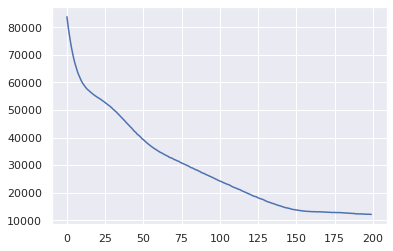

In [10]:
print("Inferred axes:")
print(qw_mean)
print("Standard Deviation:")
print(qw_stddv)

plt.plot(losses)
plt.show()

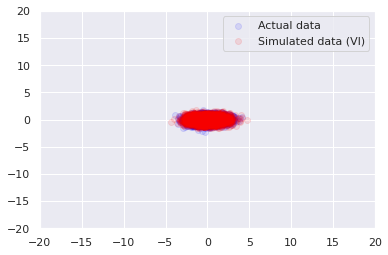

In [11]:
posterior_samples = surrogate_posterior.sample(50)
_, _, x_generated = model.sample(value=(posterior_samples))

# It's a pain to plot all 5000 points for each of our 50 posterior samples, so
# let's subsample to get the gist of the distribution.
x_generated = tf.reshape(tf.transpose(x_generated, [1, 0, 2]), (2, -1))[:, ::47]

plt.scatter(x_train[0, :], x_train[1, :], color='blue', alpha=0.1, label='Actual data')
plt.scatter(x_generated[0, :], x_generated[1, :], color='red', alpha=0.1, label='Simulated data (VI)')
plt.legend()
plt.axis([-20, 20, -20, 20])
plt.show()